In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter
import numpy as np
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
# from scipy import integrate
# from amuse.ic.kingmodel import new_king_model
from amuse.units import units
from amuse.units import quantities
from amuse.units import constants
from amuse.units import nbody_system
from tqdm import tqdm

In [2]:
class MilkyWay_galaxy(object):
    def __init__(self, 
                 Mb=1.40592e10| units.MSun,
                 Md=8.5608e10| units.MSun,
                 Mh=1.07068e11 | units.MSun):
        self.Mb= Mb
        self.Md= Md
        self.Mh= Mh

    def get_potential_at_point(self,eps,x,y,z):
        r=(x**2+y**2+z**2)**0.5
        R= (x**2+y**2)**0.5
        # buldge
        b1= 0.3873 |units.kpc
        pot_bulge= -constants.G*self.Mb/(r**2+b1**2)**0.5 
        # disk
        a2= 5.31 |units.kpc
        b2= 0.25 |units.kpc
        pot_disk = -constants.G*self.Md/(R**2 + (a2+ (z**2+ b2**2)**0.5 )**2 )**0.5
        #halo
        a3= 12.0 |units.kpc
        cut_off=100 |units.kpc
        d1= r/a3
        c=1+ (cut_off/a3)**1.02
        pot_halo= -constants.G*(self.Mh/a3)*d1**1.02/(1+ d1**1.02) \
                  - (constants.G*self.Mh/(1.02*a3))\
                      * (-1.02/c +np.log(c) + 1.02/(1+d1**1.02) \
                           - np.log(1.0 +d1**1.02) )
        return 2*(pot_bulge + pot_disk + pot_halo) # multiply by 2 because it is a rigid potential
    
    def get_gravity_at_point(self, eps, x,y,z): 
        r= (x**2+y**2+z**2)**0.5
        R= (x**2+y**2)**0.5
        #bulge
        b1= 0.3873 |units.kpc
        force_bulge= -constants.G*self.Mb/(r**2+b1**2)**1.5 
        #disk
        a2= 5.31 |units.kpc
        b2= 0.25 |units.kpc
        d= a2+ (z**2+ b2**2)**0.5
        force_disk=-constants.G*self.Md/(R**2+ d**2 )**1.5
        #halo
        a3= 12.0 |units.kpc
        d1= r/a3
        force_halo= -constants.G*self.Mh*d1**0.02/(a3**2*(1+d1**1.02))
       
        ax= force_bulge*x + force_disk*x  + force_halo*x/r
        ay= force_bulge*y + force_disk*y  + force_halo*y/r
        az= force_bulge*z + force_disk*d*z/(z**2 + b2**2)**0.5 + force_halo*z/r 

        return ax, ay, az

def mag_to_mass(MG, L0 = 3.828e26, M0 = 4.83, m0 = 1.989e30, a = 3.5, solar_masses = True):
    L = L0 * 10**(-(MG- M0)/2.5)
    if solar_masses == True:
        return (L/L0)**(1/a) 
    else:
        return m0 * (L/L0)**(1/a)

282
216.566876555 MSun
0.252094691169 MSun 3.77375374286 MSun


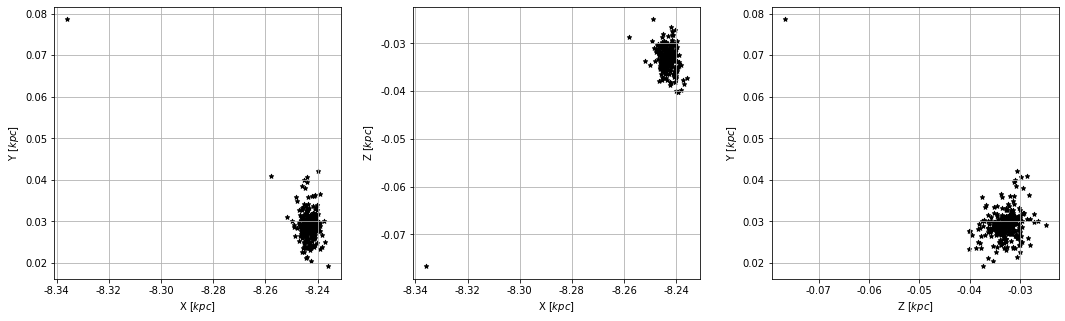

In [3]:
import astropy.units as u
import astropy.coordinates as coord

cluster = pd.read_csv('./pleiades_pm_distance.csv')
cluster = cluster[(cluster['rv'] != 0)]
print(len(cluster))
g_mag = cluster.g + 5 - 5*np.log10(cluster.distance)
m = np.array(mag_to_mass(g_mag, solar_masses=True)) |units.MSun
print(m.sum())
print(min(m), max(m))

ra = np.array(cluster['ra']) *u.deg
dec = np.array(cluster['dec']) *u.deg
distance = np.array(cluster['distance']) *u.pc
pmra = np.array(cluster['pmra']) *u.mas/u.yr
pmdec = np.array(cluster['pmdec']) *u.mas/u.yr
vlos = np.array(cluster['rv']) *u.km/u.s

c = coord.SkyCoord(ra=ra, dec=dec, distance=distance, pm_ra_cosdec=pmra,\
                   pm_dec=pmdec, radial_velocity=vlos, frame='icrs')

xm = c.transform_to(coord.Galactocentric).x
ym = c.transform_to(coord.Galactocentric).y
zm = c.transform_to(coord.Galactocentric).z

vx = c.transform_to(coord.Galactocentric).v_x
vy = c.transform_to(coord.Galactocentric).v_y
vz = c.transform_to(coord.Galactocentric).v_z

%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.25)
axs[0].scatter(xm/1000, ym/1000, c='black',marker='*',s=20, alpha=1)
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[0].set_xlabel("X $[kpc]$")
axs[0].set_ylabel("Y $[kpc]$")
axs[0].grid()

axs[1].scatter(xm/1000, zm/1000, c='black',marker='*',s=20, alpha=1)
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[1].set_xlabel("X $[kpc]$")
axs[1].set_ylabel("Z $[kpc]$")
axs[1].grid()

axs[2].scatter(zm/1000, ym/1000, c='black',marker='*',s=20, alpha=1)
axs[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[2].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[2].set_xlabel("Z $[kpc]$")
axs[2].set_ylabel("Y $[kpc]$")
axs[2].grid()
#plt.savefig('./2d.jpg')
plt.show()

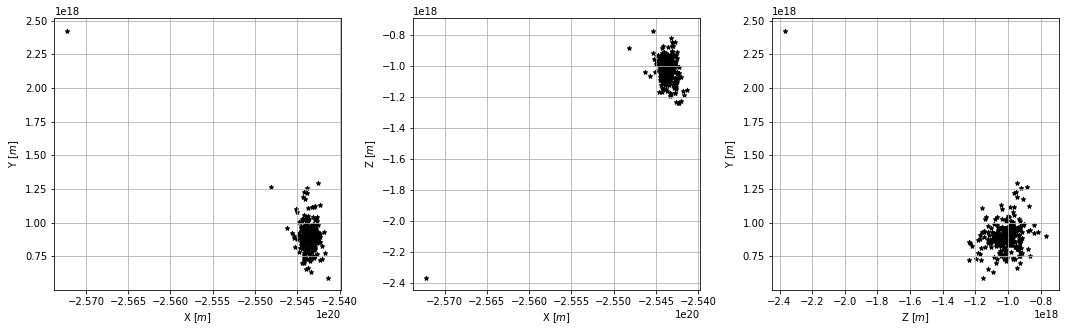

In [4]:
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.lab import new_plummer_model
from amuse.lab import new_powerlaw_mass_distribution

N = len(cluster)
Rcluster = 1.0 | units.parsec
alpha_IMF = -2.35
m_stars = new_powerlaw_mass_distribution(N, 0.2|units.MSun, 5.0|units.MSun, alpha_IMF)
converter = nbody_system.nbody_to_si(m_stars.sum(), Rcluster)
stars = new_plummer_model(N, convert_nbody = converter)
#stars = Particles(N)

stars.mass = m_stars
stars.x = xm.value | units.parsec
stars.y = ym.value | units.parsec
stars.z = zm.value | units.parsec
stars.vx = vx.value | units.kms
stars.vy = vy.value | units.kms
stars.vz = vz.value | units.kms
converter = nbody_system.nbody_to_si(stars.mass.sum(), stars.position.length())
#print(sum(np.array(stars.mass.value_in(units.kg))))

fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(wspace=0.25)
plt.subplot(1,3,1)
plt.scatter(stars.x.number, stars.y.number, c='black',marker='*',s=20, alpha=1)
plt.xlabel("X $[m]$")
plt.ylabel("Y $[m]$")
plt.grid()

plt.subplot(1,3,2)
plt.scatter(stars.x.number, stars.z.number, c='black',marker='*',s=20, alpha=1)
plt.xlabel("X $[m]$")
plt.ylabel("Z $[m]$")
plt.grid()

plt.subplot(1,3,3)
plt.scatter(stars.z.number, stars.y.number, c='black',marker='*',s=20, alpha=1)
plt.xlabel("Z $[m]$")
plt.ylabel("Y $[m]$")
plt.grid()
#plt.savefig('./2d.jpg')
plt.show()

In [5]:
xm_mean = np.mean(xm)
print(xm_mean)
print(np.mean(stars.x.in_(units.pc)))

# print(stars.center_of_mass_velocity.in_(units.ms))

-8243.636248228411 pc
-8243.63624823 parsec


# Gravity

In [6]:
# from amuse.community.hermite.interface import Hermite
# %matplotlib inline
# gravity_code = Hermite(converter)
# gravity_code.particles.add_particles(stars)
# channel = gravity_code.particles.new_channel_to(stars)

# MWG = MilkyWay_galaxy()

# from amuse.couple import bridge
# gravity = bridge.Bridge(use_threading=False)
# gravity.add_system(gravity_code,(MWG,))

# timestep = 0.1 | units.Myr
# endtime = 50 | units.Myr
# times = quantities.arange(0|units.Myr, endtime, timestep)

# x = [] | units.pc
# y = [] | units.pc
# z = [] | units.pc
# cm = [] | units.pc
# r_virial = [] | units.parsec
# mass_ = [] | units.MSun
# energy = [] | units.m**2 * units.kg * units.s**-2
# kinetic = [] | units.m**2 * units.kg * units.s**-2
# potential = [] | units.m**2 * units.kg * units.s**-2

# for i in tqdm(times):
#     gravity.evolve_model(i)
#     channel.copy()
# #     x.append(gravity.particles.x.value_in(units.parsec))  
# #     y.append(gravity.particles.y.value_in(units.parsec))
# #     z.append(gravity.particles.z.value_in(units.parsec))
#     x.append(stars.x)
#     y.append(stars.y)
#     z.append(stars.z)
#     cm.append(gravity.particles.center_of_mass())
#     r_virial.append(stars.virial_radius().in_(units.pc))
#     mass_.append(stars.mass.sum().in_(units.MSun))
#     energy.append(gravity.potential_energy + gravity.kinetic_energy)
#     kinetic.append(gravity.kinetic_energy)
#     potential.append(gravity.potential_energy)
#     #L.append(LagrangianRadii(bodies))
# gravity.stop()

In [7]:
# np.savetxt('./results_nbody/x.out', x, delimiter=',')
# np.savetxt('./results_nbody/y.out', y, delimiter=',')
# np.savetxt('./results_nbody/z.out', z, delimiter=',')
# np.savetxt('./results_nbody/r_virial.out', r_virial.number, delimiter=',')
# np.savetxt('./results_nbody/times.out', times.number, delimiter=',')
# x = np.loadtxt('./results_nbody/x.out',delimiter=',')
# y = np.loadtxt('./results_nbody/y.out',delimiter=',')
# plt.plot(x, y, lw=1, ls='--')
# plt.show()

# Gravity and Stellar

In [6]:
#from amuse.community.hermite.interface import Hermite
# from amuse.community.bhtree.interface import BHTree
from amuse.community.huayno.interface import Huayno
from amuse.community.seba.interface import SeBa
from amuse.ext.LagrangianRadii import LagrangianRadii
%matplotlib inline
# #stars.scale_to_standard(converter)

stellar = SeBa()
stellar.particles.add_particles(stars)
gravity_code = Huayno(converter)
gravity_code.particles.add_particles(stars)

from amuse.couple import bridge
gravity = bridge.Bridge(use_threading=False)
MWG = MilkyWay_galaxy()
gravity.add_system(gravity_code, (MWG,))

ch_s2g = stellar.particles.new_channel_to(gravity.particles)
ch_g2l = gravity.particles.new_channel_to(stars)
ch_s2l = stellar.particles.new_channel_to(stars)
ch_s2l.copy()

timestep = 0.1 | units.Myr
endtime = 1000 | units.Myr
times = quantities.arange(0|units.Myr, endtime, timestep)

x = [] | units.pc
y = [] | units.pc
z = [] | units.pc
cm = [] | units.pc
r_virial = [] | units.pc
masses = [] | units.MSun
kinetic = [] | units.m**2 * units.kg * units.s**-2
potential = [] | units.m**2 * units.kg * units.s**-2
#L_angular = [] |units.kg * units.m**2 * units.s 

for i in tqdm(times):
    stellar.evolve_model(i)
    ch_s2g.copy()
    ch_s2l.copy()
    gravity.evolve_model(i)
    ch_g2l.copy()
    x.append(stars.x)
    y.append(stars.y)
    z.append(stars.z)
    cm.append(gravity.particles.center_of_mass())
    r_virial.append(stars.virial_radius().in_(units.pc))
    #L_angular.append(stars.angular_momentum())
    masses.append(stellar.particles.mass.sum().in_(units.MSun))
    kinetic.append(gravity.kinetic_energy)
    potential.append(gravity.potential_energy)
stellar.stop()
gravity.stop()

100%|██████████| 10000/10000 [12:06<00:00, 13.77it/s]


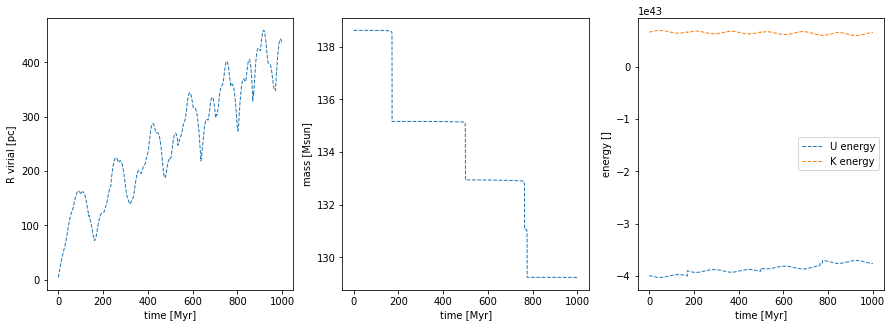

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(times.number, r_virial.number, lw=1, ls='--')
plt.xlabel('time [Myr]')
plt.ylabel('R virial [pc]')

plt.subplot(1,3,2)
plt.plot(times.number, masses.number,lw=1, ls='--')
plt.xlabel('time [Myr]')
plt.ylabel('mass [Msun]')

plt.subplot(1,3,3)
#plt.plot(times.number, energy.number, lw=1, ls='-',label='Etot')
plt.plot(times.number, potential.number, lw=1, ls='--',label='U energy')
plt.plot(times.number, kinetic.number, lw=1, ls='--', label='K energy')
plt.xlabel('time [Myr]')
plt.ylabel('energy []')
plt.legend()
plt.show()

Text(0, 0.5, 'z [kpc]')

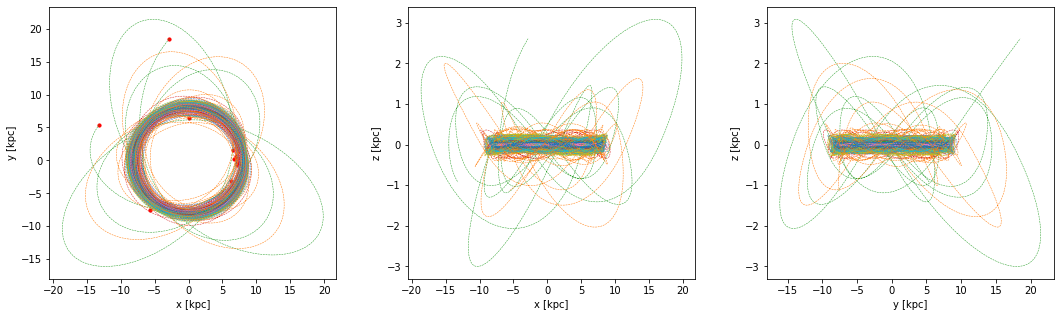

In [14]:
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(wspace=0.25)

plt.subplot(1,3,1)
plt.plot(x.value_in(units.kpc), y.value_in(units.kpc), lw=0.5, ls='--')
plt.scatter(x.value_in(units.kpc)[0], y.value_in(units.kpc)[0], s=10,color='black')
plt.scatter(x.value_in(units.kpc)[-1], y.value_in(units.kpc)[-1], s=10,color='red')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')

plt.subplot(1,3,2)
plt.plot(x.value_in(units.kpc), z.value_in(units.kpc), lw=0.5, ls='--')
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')

plt.subplot(1,3,3)
plt.plot(y.value_in(units.kpc), z.value_in(units.kpc), lw=0.5, ls='--')
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
#plt.savefig('./evolution_pos.png',bbox_inches='tight')

Text(0, 0.5, 'y [pc]')

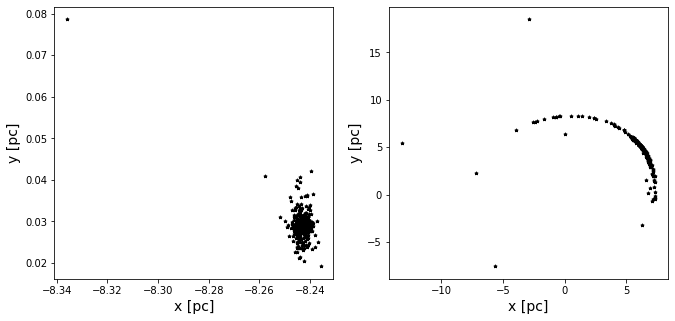

In [15]:
plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.scatter(x.value_in(units.kpc)[0], y.value_in(units.kpc)[0], s=10,color='black',marker='*')
plt.xlabel('x [pc]',fontsize=14)
plt.ylabel('y [pc]',fontsize=14)

plt.subplot(1,2,2)
plt.scatter(x.value_in(units.kpc)[-1], y.value_in(units.kpc)[-1], s=10,color='black',marker='*')
plt.xlabel('x [pc]',fontsize=14)
plt.ylabel('y [pc]',fontsize=14)
#plt.savefig('./evolution_tidal.png',bbox_inches='tight')

Text(0, 0.5, 'z [kpc]')

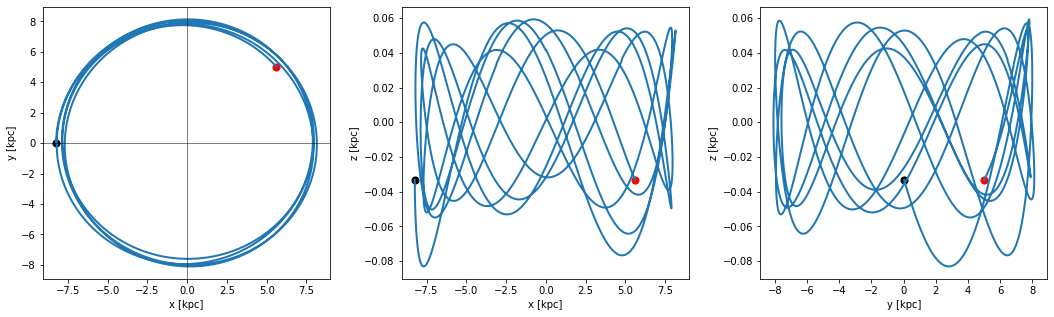

In [16]:
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(wspace=0.25)

plt.subplot(1,3,1)
plt.plot(cm.value_in(units.kpc)[:,0], cm.value_in(units.kpc)[:,1], lw=2, ls='-')
plt.scatter(cm.value_in(units.kpc)[0][0], cm.value_in(units.kpc)[0][1], s=50,color='black')
plt.scatter(cm.value_in(units.kpc)[-1][0], cm.value_in(units.kpc)[-1][1], s=50,color='red')
plt.axvline(0,c='k',lw=0.5)
plt.axhline(0,c='k',lw=0.5)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')

plt.subplot(1,3,2)
plt.plot(cm.value_in(units.kpc)[:,0], cm.value_in(units.kpc)[:,2], lw=2, ls='-')
plt.scatter(cm.value_in(units.kpc)[0][0], cm.value_in(units.kpc)[0][2], s=50,color='black')
plt.scatter(cm.value_in(units.kpc)[-1][0], cm.value_in(units.kpc)[-1][2], s=50,color='red')
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')

plt.subplot(1,3,3)
plt.plot(cm.value_in(units.kpc)[:,1], cm.value_in(units.kpc)[:,2], lw=2, ls='-')
plt.scatter(cm.value_in(units.kpc)[0][1], cm.value_in(units.kpc)[0][2], s=50,color='black')
plt.scatter(cm.value_in(units.kpc)[-1][1], cm.value_in(units.kpc)[-1][2], s=50,color='red')
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
#plt.savefig('./evolution_pos.png',bbox_inches='tight')

<IPython.core.display.Javascript object>


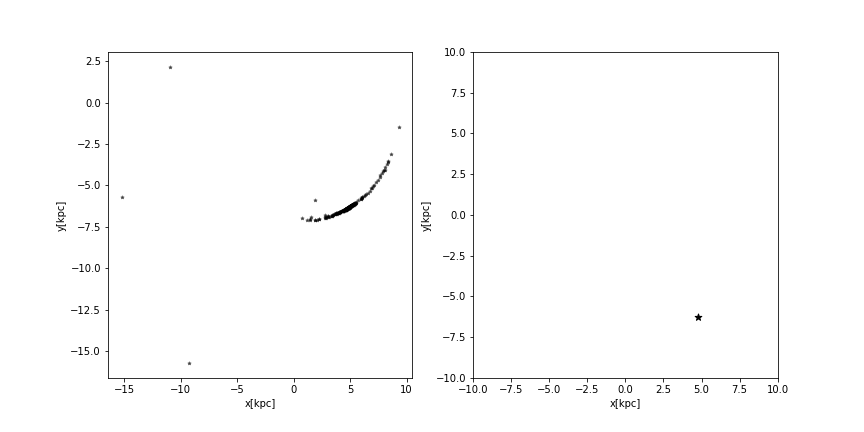

In [21]:
%matplotlib notebook
import matplotlib.animation as anim

NFrames = len(x)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

def init():
    ax1.set_xlabel('x[kpc]')
    ax1.set_ylabel('y[kpc]')
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    
    ax2.set_xlabel('x[kpc]')
    ax2.set_ylabel('y[kpc]')
    ax2.set_xlim(-10,10)
    ax2.set_ylim(-10,10)
    #ax2.set_xticks([])
    #ax2.set_yticks([])
    
# Definamos funcion de actualizacion
def Update(i):
    plot1 = ax1.clear()
    plot2 = ax2.clear()
    init()
    plot1 = ax1.scatter(x.value_in(units.kpc)[i],y.value_in(units.kpc)[i],s=10,alpha=0.5,c='k',marker='*')
    plot2 = ax2.scatter(cm.value_in(units.kpc)[i][0],cm.value_in(units.kpc)[i][1],s=50,c='k',marker='*')
    return plot1, plot2

Animation = anim.FuncAnimation(fig, Update, frames=NFrames, init_func=init, interval=0.1)

In [22]:
Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=50, metadata=dict(artist='Me'))
Animation.save('./PleiadesEvolution.mp4', writer=writer_)